## Process Visiopharm output

- 40 brains embedded, sectioned, stained, and mounted onto slides
- 8x5 grid per slide (n=8 conditions, n=5 per condition, n=5 stains), ~9000 sections
- GFAP and Iba1 = 210 um between slides; TH, TPH, and KOR = 420 um between slides
- brains were not embedded perfectly so there is some rostral-caudal variability (see example slide below)

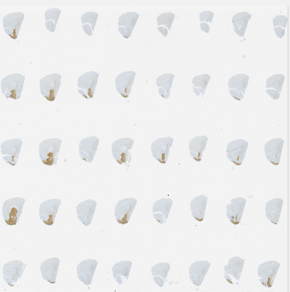

- train supervised ML algo to predict Allen Brain Atlas slide number
- Schindler lab reserach assistants labeled 400+ sections as training data

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics

import shap
# load JS visualization code to notebook
shap.initjs()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Create data frame

#### Get data

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/Section_210126.xlsx'

data = pd.read_excel(path)
data = pd.DataFrame(data = data)
print(data.shape)
print(data.columns)

data.head()

(1400, 13)
Index(['Measurement', 'Details', 'Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 'Section_majoraxis', 'Section_area'], dtype='object')


,Measurement,Details,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area
0,TPH_18,"(A, 1)",1.082666,-0.488130,0.962867,0.941435,0.766138,0.410729,0.788606,19122.25586,4952.459473,5957.475586,22296820.0
1,TPH_18,"(A, 2)",0.992096,-0.578700,0.967661,0.938657,0.766095,0.491365,0.845021,19071.19922,4696.720215,6191.622559,22171186.0
2,TPH_18,"(A, 3)",1.177290,-0.393506,0.957936,0.928447,0.734825,0.436342,0.804752,19559.06250,4905.334473,6058.918945,22371632.0
3,TPH_18,"(A, 4)",0.855663,-0.715133,0.971253,0.944064,0.766610,0.494284,0.831397,18604.15234,4575.995117,6055.441406,21116092.0
4,TPH_18,"(A, 5)",0.984838,-0.585959,0.959587,0.941400,0.750860,0.472052,0.790953,18733.26367,4648.758789,5981.671875,20970534.0


In [3]:
#fix TH measurement variables
data['Measurement'] = [str('TH_' + str(x)) if len(str(x)) < 3 else x for x in data['Measurement']]
#add stain column
data['Stain'] = [x.split('_')[0] for x in data['Measurement'].values]
data['Slide'] = [x.split('_')[1] for x in data['Measurement'].values]
data['Letter'] = [x.split(',')[0].split('(')[1] for x in data['Details'].values]
data['Number'] = [int(x.split(',')[1].split(')')[0]) for x in data['Details'].values]

data.drop(['Measurement', 'Details'], axis=1, inplace=True)

print(data.shape)
data.head()

(1400, 15)


,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area,Stain,Slide,Letter,Number
0,1.082666,-0.488130,0.962867,0.941435,0.766138,0.410729,0.788606,19122.25586,4952.459473,5957.475586,22296820.0,TPH,18,A,1
1,0.992096,-0.578700,0.967661,0.938657,0.766095,0.491365,0.845021,19071.19922,4696.720215,6191.622559,22171186.0,TPH,18,A,2
2,1.177290,-0.393506,0.957936,0.928447,0.734825,0.436342,0.804752,19559.06250,4905.334473,6058.918945,22371632.0,TPH,18,A,3
3,0.855663,-0.715133,0.971253,0.944064,0.766610,0.494284,0.831397,18604.15234,4575.995117,6055.441406,21116092.0,TPH,18,A,4
4,0.984838,-0.585959,0.959587,0.941400,0.750860,0.472052,0.790953,18733.26367,4648.758789,5981.671875,20970534.0,TPH,18,A,5


In [4]:
data['Stain'].value_counts()

TH      1000
GFAP     360
TPH       40
Name: Stain, dtype: int64

#### Get labels

In [5]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels'

dir_path_list = os.listdir(orig_path)

labels_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    labels_dir_paths.append(int_path)
    
labels_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit1.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Katrina.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Kathryn.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Omkar1.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Emma.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Saiyara.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit.xlsx',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/or

In [62]:
labels_final = pd.DataFrame()

for path in labels_dir_paths:
    print(path)
    if path.split('/')[-1] == '.DS_Store':
        pass 
    else:
        labels_int = pd.read_excel(path)
        labels_int = pd.DataFrame(data = labels_int)
        labels_int['name'] = path.split('/')[-1]
        print(labels_int.shape)
        print(labels_int.columns)
    
        if labels_final.shape[0] < 1:
            labels_final = labels_int
        else: 
            labels_final = pd.concat([labels_final, labels_int], axis=0)
    
    print(labels_final.shape, '\n')
    
labels_final.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/.DS_Store
(0, 0) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Harmanjit1.xlsx
(40, 7)
Index(['Stain', 'Letter', 'Number', 'Slide_28', 'Slide_32', 'Slide_36', 'name'], dtype='object')
(40, 7) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Katrina.xlsx
(8, 17)
Index(['Stain', 'Letter', 'Number', 'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19', 'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29', 'Slide_31', 'Slide_33', 'Slide_35', 'name'], dtype='object')
(48, 20) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Whole_section_analysis/labels/Kathryn.xlsx
(40, 7)
Index(['Stain', 'Letter', 'Number', 'Slide_12', 'Slide_14', 'Slide_16', 'name'], dtype='object')
(88, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/orig_tc/Wh

,Stain,Letter,Number,Slide_28,Slide_32,Slide_36,name,Slide_11,Slide_13,Slide_15,Slide_17,Slide_19,Slide_21,Slide_23,Slide_25,Slide_27,Slide_29,Slide_31,Slide_33,Slide_35,Slide_12,Slide_14,Slide_16,Slide_62,Slide_65,Slide_69,Slide_20,Slide_24,Slide_52,Slide_56,Slide_60,Slide_40,Slide_44,Slide_48
35,GFAP,H,1,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,76.0,85.0
36,GFAP,H,2,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,78.0,86.0
37,GFAP,H,3,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,80.0,88.0
38,GFAP,H,4,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,78.0,86.0
39,GFAP,H,5,NaN,NaN,NaN,Katrina1.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,81.0,89.0


In [63]:
#make tidy
slides = ['Slide_28', 'Slide_32', 'Slide_36',
       'Slide_11', 'Slide_13', 'Slide_15', 'Slide_17', 'Slide_19',
       'Slide_21', 'Slide_23', 'Slide_25', 'Slide_27', 'Slide_29',
       'Slide_31', 'Slide_33', 'Slide_35', 'Slide_12', 'Slide_14',
       'Slide_16', 'Slide_62', 'Slide_65', 'Slide_69', 'Slide_20',
       'Slide_24', 'Slide_52', 'Slide_56', 'Slide_60', 
       'Slide_40', 'Slide_44', 'Slide_48']

labels_final_melt = pd.melt(labels_final, id_vars=['Stain', 'Letter', 'Number'], value_vars=slides,
              var_name='Slide', value_name='ABA_slide')

labels_final_melt = labels_final_melt[labels_final_melt['ABA_slide']!='130-131']
labels_final_melt = labels_final_melt.replace({'none': np.nan})
labels_final_melt = labels_final_melt.dropna(axis=0)

#clean
labels_final_melt['Slide'] = [x.split('_')[1] for x in labels_final_melt['Slide']]
labels_final_melt['ABA_slide'] = [int(x) for x in labels_final_melt['ABA_slide']]                                                          

print(labels_final_melt.shape)
labels_final_melt.head()

(1230, 5)


,Stain,Letter,Number,Slide,ABA_slide
0,GFAP,A,1,28,51
1,GFAP,A,2,28,53
2,GFAP,A,3,28,53
3,GFAP,A,4,28,54
4,GFAP,A,5,28,55


In [20]:
#get count of aba slide labels, filter out anything with less than 5 data points
ABA_slide_count = labels_final_melt.groupby(['ABA_slide'])['ABA_slide'].count().reset_index(name='ABA_slide_count')
slides_keep = ABA_slide_count[ABA_slide_count['ABA_slide_count']>4]['ABA_slide'].values

labels_final_melt_clean = labels_final_melt[labels_final_melt['ABA_slide'].isin(slides_keep)]

print(labels_final_melt_clean.shape)
labels_final_melt_clean.head()

(1180, 5)


,Stain,Letter,Number,Slide,ABA_slide
0,GFAP,A,1,28,51
1,GFAP,A,2,28,53
2,GFAP,A,3,28,53
3,GFAP,A,4,28,54
4,GFAP,A,5,28,55


#### Combine

In [64]:
data_final = labels_final_melt.merge(data, on=['Stain', 'Letter', 'Number', 'Slide'], how='inner')
print(data_final.shape)
data_final.head()

(710, 16)


,Stain,Letter,Number,Slide,ABA_slide,Section_OriH,Section_OriV,Section_Sol,Section_Convex,Section_FF,Section_Eccen,Section_Elip,Section_perim,Section_minoraxis,Section_majoraxis,Section_area
0,TH,A,3,11,36,1.412264,-0.158533,0.980361,0.938887,0.781393,0.480173,0.798811,14087.372070,3542.217041,4603.665039,12335848.0
1,TH,B,3,11,38,1.245366,-0.325430,0.981867,0.942924,0.797256,0.507306,0.838076,14668.124023,3642.072754,4904.218262,13653189.0
2,TH,C,3,11,34,1.258788,-0.312008,0.987182,0.946068,0.804527,0.543905,0.842605,13731.907227,3329.501709,4728.282227,12071973.0
3,TH,D,3,11,37,1.532517,-0.038279,0.981651,0.937917,0.787888,0.478579,0.828710,14918.103516,3759.357666,4876.187500,13956910.0
4,TH,E,3,11,37,1.183437,-0.387359,0.982587,0.941690,0.779833,0.472157,0.801247,13939.053711,3527.260986,4539.192383,12056929.0


In [65]:
data_final['Stain'].value_counts()

TH      632
GFAP     78
Name: Stain, dtype: int64

### Explore features

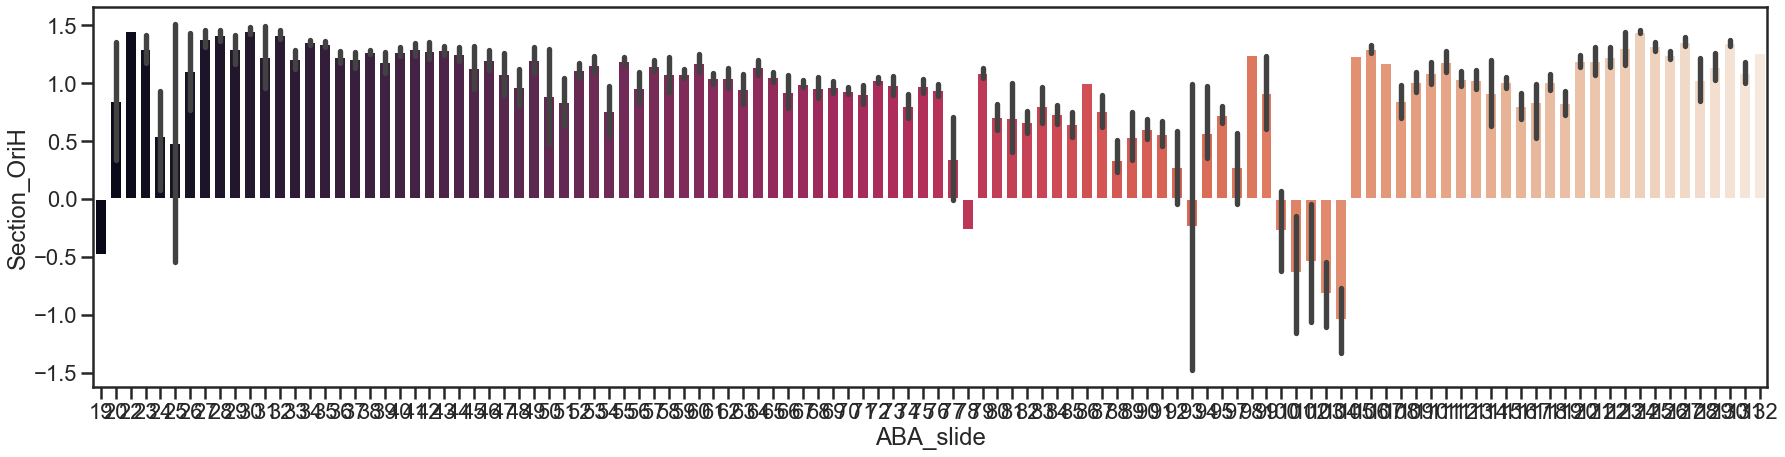

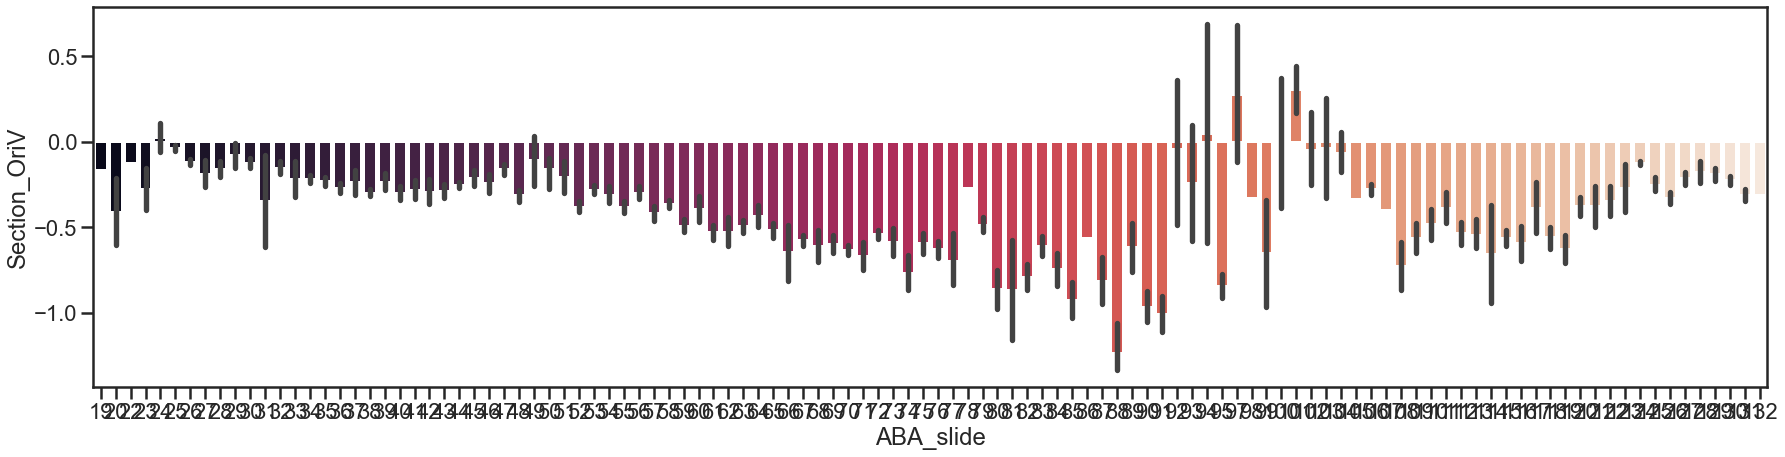

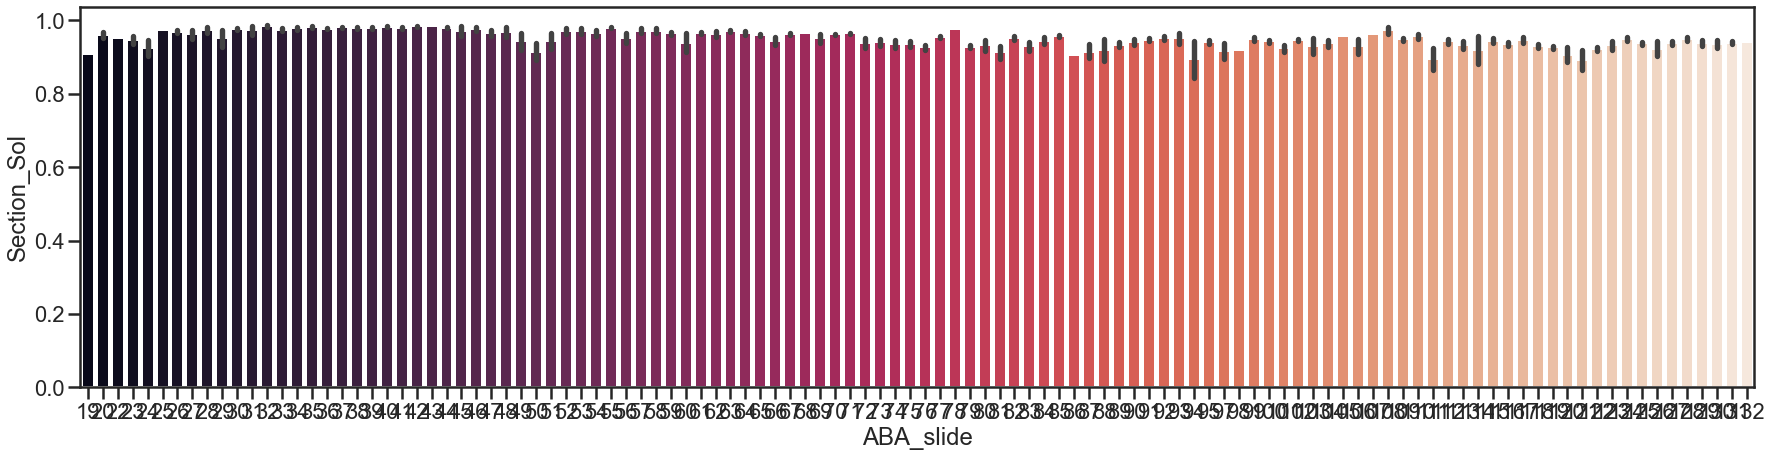

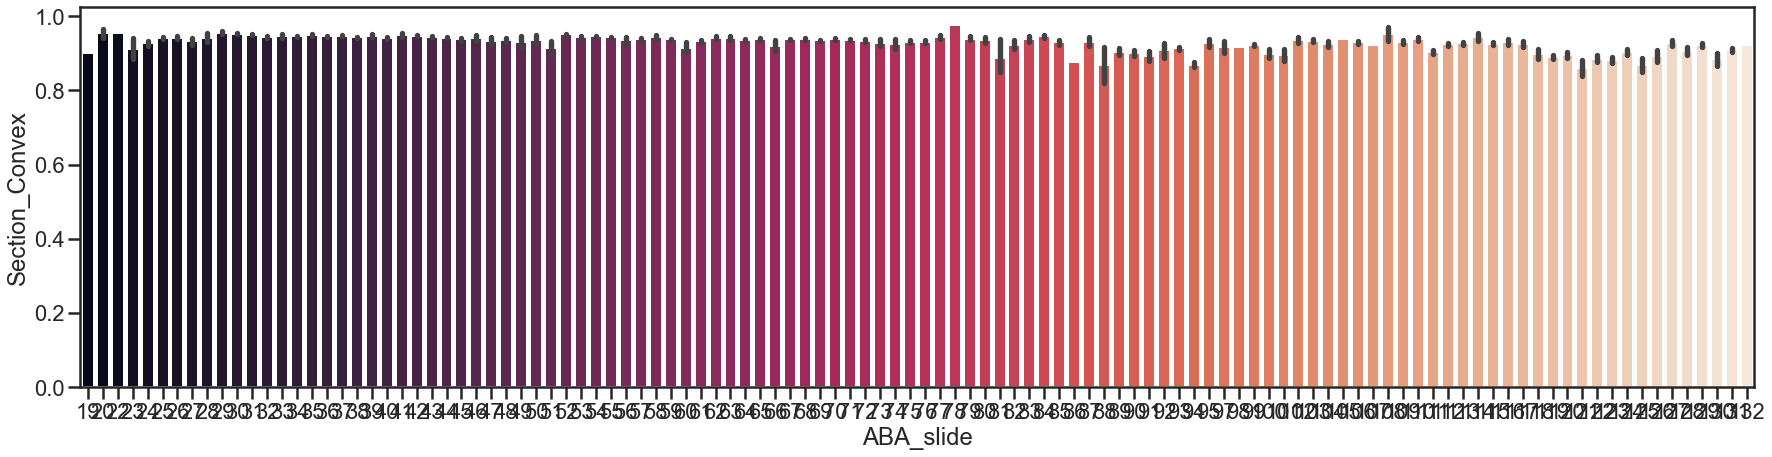

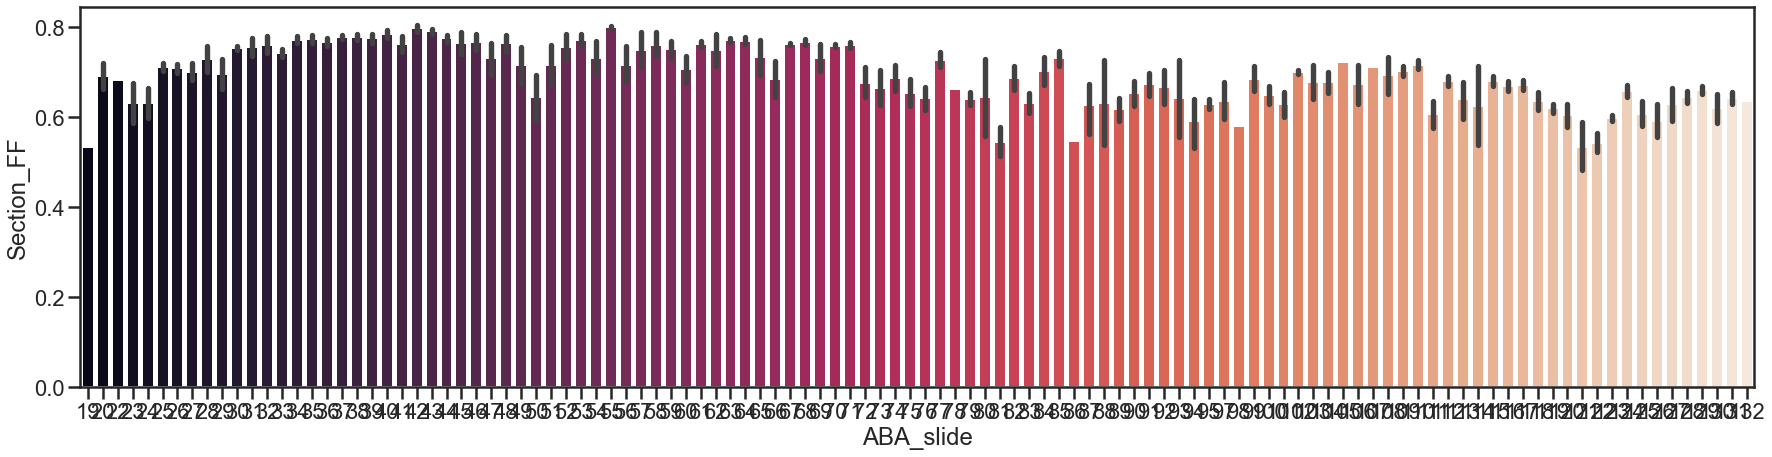

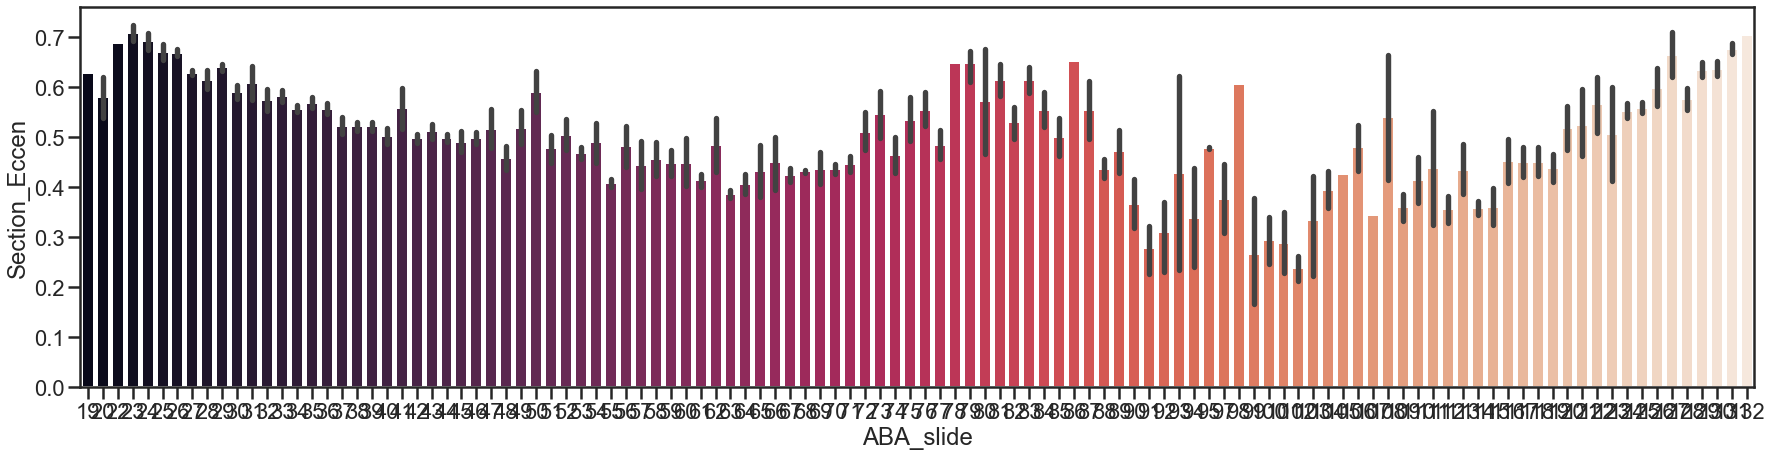

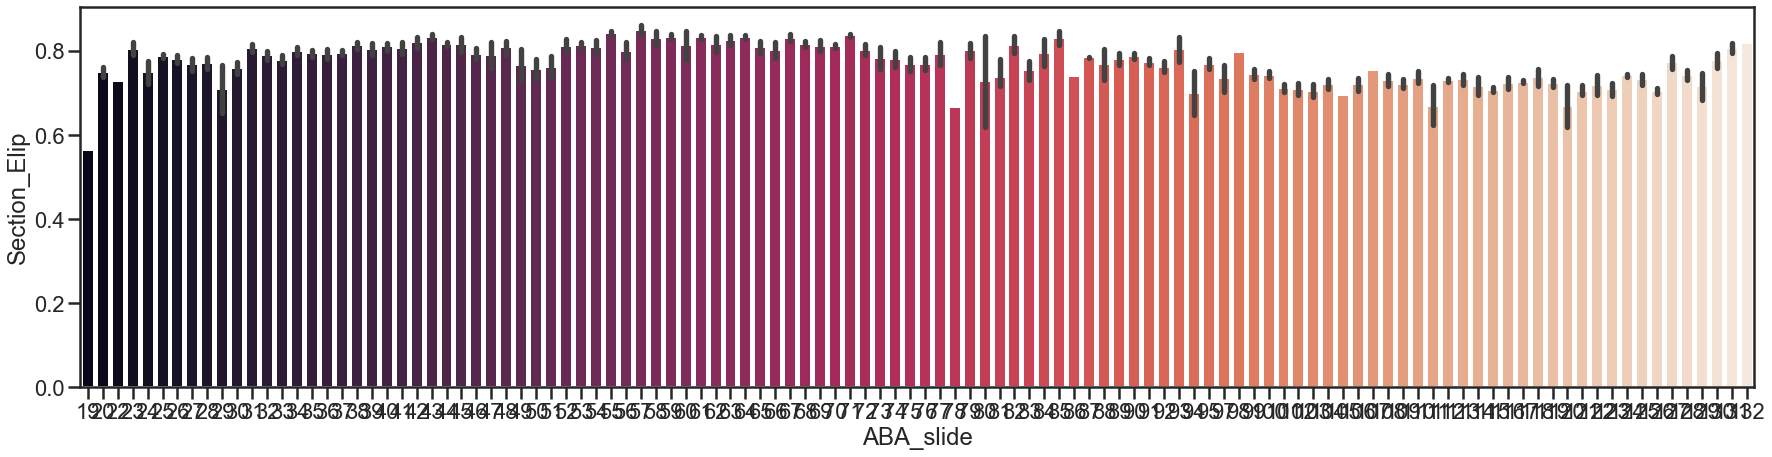

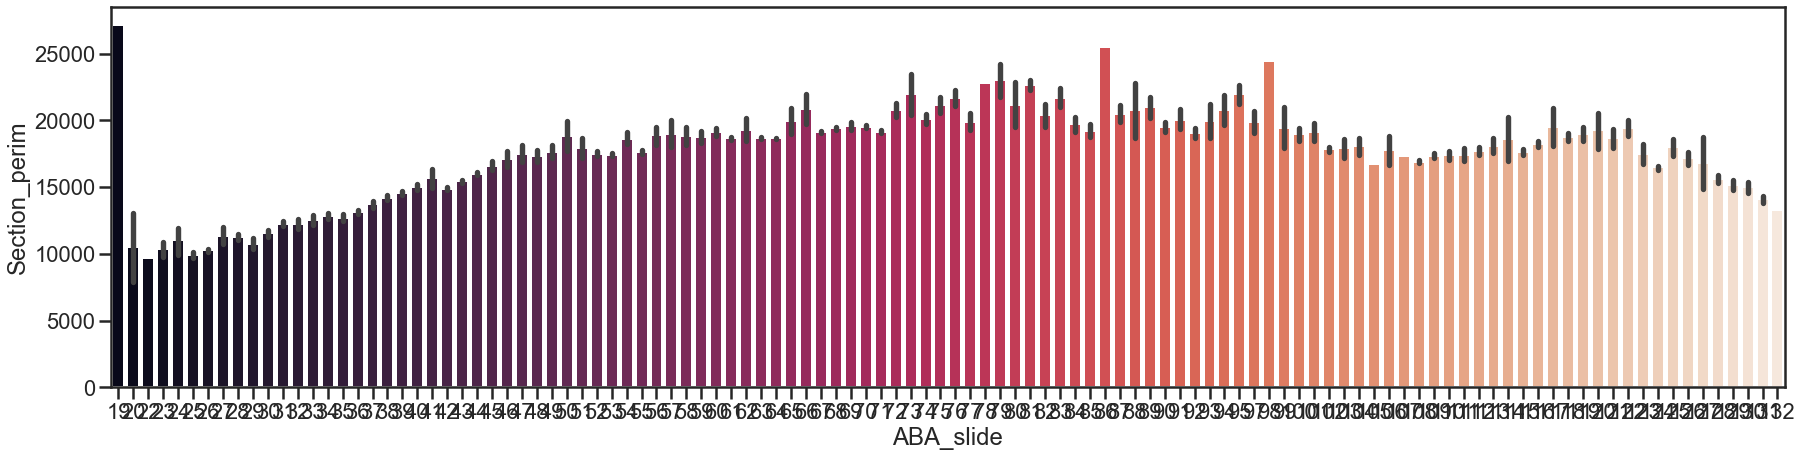

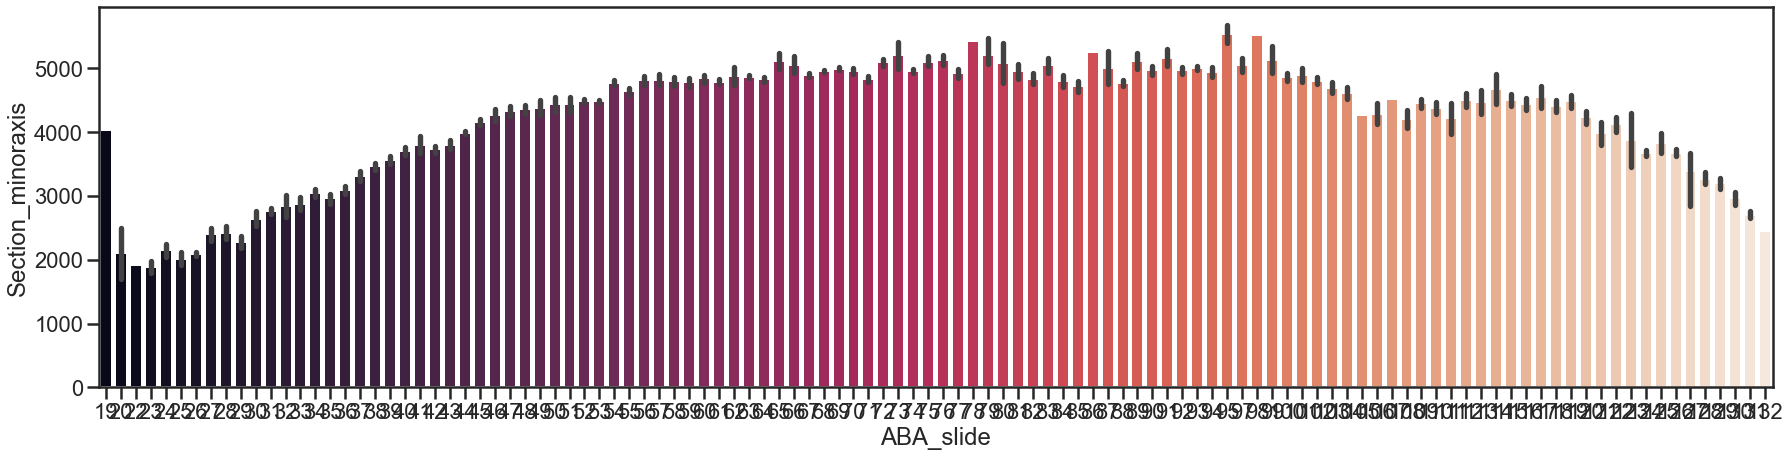

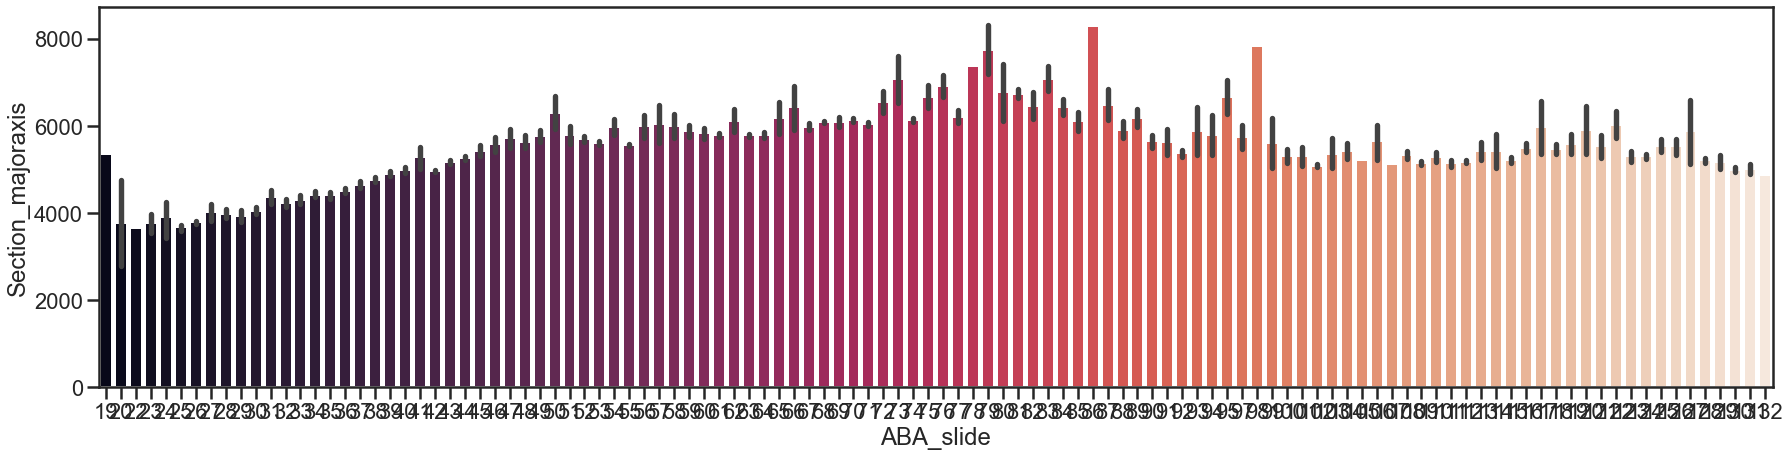

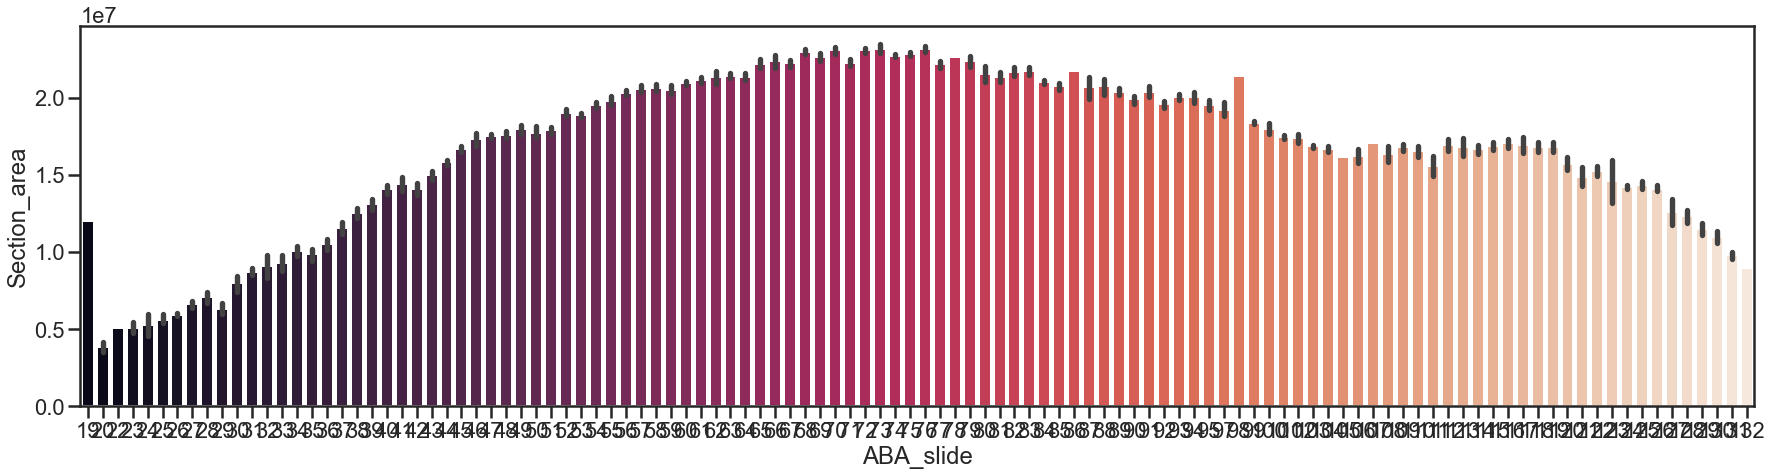

In [66]:
cols = ['Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 
        'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 'Section_majoraxis', 'Section_area']

for variable in cols:
    try:
        plt.figure(figsize=(30,7))
        g = sns.barplot(x='ABA_slide', y=variable, data=data_final, ci=68, palette="rocket")
        plt.show()
    except:
        pass

### Predict ABA slide number

In [67]:
data_predict = data_final.dropna().reset_index()
print(data_predict.shape)

#split data
train, test = train_test_split(data_predict, test_size = .3, random_state=39)

Y_train = train['ABA_slide']
Y_test = test['ABA_slide']

#create feature sets
features = ['Section_OriH', 'Section_OriV', 'Section_Sol', 'Section_Convex', 'Section_FF', 
            'Section_Eccen', 'Section_Elip', 'Section_perim', 'Section_minoraxis', 
            'Section_majoraxis', 'Section_area']

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

(710, 17)


In [74]:
#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

#classifier algos
dm = DummyRegressor()
lr = linear_model.LinearRegression()
rg = linear_model.Ridge()
rf = RandomForestRegressor(random_state=39)
knn = neighbors.KNeighborsRegressor()
bay = linear_model.BayesianRidge()
svr = svm.SVR()

model = rf 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
mean_squared_error = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='neg_mean_absolute_error')
print('mean_squared_error = ', mean_squared_error.mean())
r2 = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='r2')
print('r2 = ', r2.mean())
explained_variance = cross_val_score(model, train_scaled, Y_train, cv=cv, scoring='explained_variance')
print('explained_variance = ', explained_variance.mean())

model.fit(train_scaled, Y_train)
print('\n')

#evaluate on test set
y_pred = model.predict(test_scaled)
print('r2 = ', metrics.r2_score(Y_test, y_pred))
print('explained_variance = ',metrics.explained_variance_score(Y_test, y_pred))
print('mean_absolute_error = ', metrics.mean_absolute_error(Y_test, y_pred))

mean_squared_error =  -6.502318367346939
r2 =  0.8038738804030945
explained_variance =  0.807508614035956


r2 =  0.8485678942929089
explained_variance =  0.8509516186415753
mean_absolute_error =  6.909107981220656




Feature ranking:
1. feature 2 (0.449910)
2. feature 10 (0.271848)
3. feature 9 (0.065545)
4. feature 0 (0.041394)
5. feature 7 (0.037123)
6. feature 8 (0.034282)
7. feature 4 (0.031358)
8. feature 6 (0.024521)
9. feature 1 (0.020968)
10. feature 5 (0.012428)
11. feature 3 (0.010623)


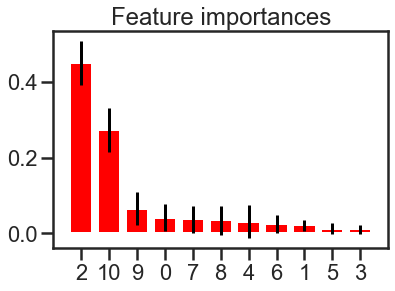

In [75]:
forest = rf
forest.fit(train_scaled, Y_train)
print('\n')

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

X = train_scaled
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [76]:
r2_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_scaled, Y_train)  #fit the model
    y_pred=model.predict(test_scaled) #make prediction on test set
    r2 = metrics.r2_score(Y_test, y_pred) #calculate r2
    r2_val.append(r2) #store r2 values
    print('r2 value for k= ' , K , 'is:', r2)

r2 value for k=  1 is: 0.6128248179241474
r2 value for k=  2 is: 0.7722567009933856
r2 value for k=  3 is: 0.7862677499931788
r2 value for k=  4 is: 0.8010759207996492
r2 value for k=  5 is: 0.7906816975035198
r2 value for k=  6 is: 0.783674207647369
r2 value for k=  7 is: 0.782416612377727
r2 value for k=  8 is: 0.7893618515923713
r2 value for k=  9 is: 0.7827751313000294
r2 value for k=  10 is: 0.789730596100241
r2 value for k=  11 is: 0.7947808928387786
r2 value for k=  12 is: 0.7971446016998285
r2 value for k=  13 is: 0.7850665984485939
r2 value for k=  14 is: 0.776217540051154
r2 value for k=  15 is: 0.7715510264853063
r2 value for k=  16 is: 0.7643068861263308
r2 value for k=  17 is: 0.766647486592508
r2 value for k=  18 is: 0.7654167759556477
r2 value for k=  19 is: 0.7560754432580973
r2 value for k=  20 is: 0.7495054967846484
r2 value for k=  21 is: 0.7475972933775307
r2 value for k=  22 is: 0.743310820383348
r2 value for k=  23 is: 0.7451233871879119
r2 value for k=  24 is: 0.

<AxesSubplot:>

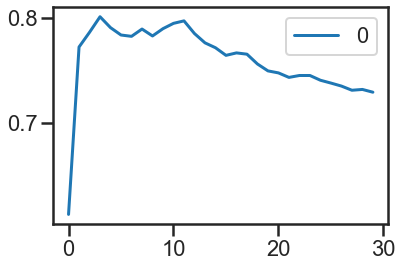

In [77]:
#plotting the rmse values against k values
curve = pd.DataFrame(r2_val) #elbow curve 
curve.plot()

In [78]:
model.fit(train_scaled, Y_train)
print('\n')

explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

Using 497 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X_train)